In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2 as T
import tqdm
import wandb
import cv2
import skdim
import torchvision
import pytorch_lightning as pl

import imageio.v3 as iio

sys.path.insert(0, os.path.abspath("python_packages"))
from python_packages import *
from src import *


# Add the Mirai_Risk_Prediction_Model directory to the Python path
sys.path.append('Mirai_Risk_Prediction_Model')
# Also add the current directory to ensure all modules can be found
sys.path.append('.')

In [2]:
from Mirai_Risk_Prediction_Model.asymmetry_model.mirai_localized_dif_head import extract_mirai_backbone

In [3]:
encoder = extract_mirai_backbone('Mirai_Risk_Prediction_Model/asymmetry_model/mgh_mammo_MIRAI_Base_May20_2019.p')

In [4]:
breast_loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="images_png_396",
    image_format="png",
    norm_kind="dataset_zscore",
    batch_size=32,  
    num_workers=1,
    task=1,
)

model = Two_view_model.load_from_checkpoint('artifacts/model-9a0gw17z:v0/model.ckpt')
model_dens = Two_view_model.load_from_checkpoint('artifacts/model-8hidkyff:v0/model.ckpt')

In [5]:
def get_featurized_data(dataloader, model, model1):
    """
    Get the full featurized dataset from a dataloader.
    """
    model.to('mps')
    model.eval()
    model1.to('mps')
    model1.eval()
    with torch.no_grad():
        all_in_features = []
        all_in_features1 = []

        all_labels = []
        all_labels1 = []

        for batch in tqdm.tqdm(dataloader, desc="Featurizing dataset"):
            x, y1, y2 = batch
            #y = y1 if model.task == 1 else y2
            x = [item.to('mps') for item in x]
            y1 = y1.to('mps')
            y2 = y2.to('mps')
            all_labels.append(y1)
            all_labels1.append(y2)
            
            x2 = [model.resnets[i](image) for i, image in enumerate(x)]
            
            x4 = [model1.resnets[i](image) for i, image in enumerate(x)]

            all_in_features.append(torch.cat(x2, dim=1))
            
            all_in_features1.append(torch.cat(x4, dim=1))
            
        all_in_features = torch.cat(all_in_features, dim=0)
        all_in_features1 = torch.cat(all_in_features1, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        all_labels1 = torch.cat(all_labels1, dim=0)

    return all_in_features, all_labels, all_in_features1, all_labels1

In [6]:
def process_and_save_all_splits(breast_loader, model, model_dens, save_dir='saved_features'):
    """
    Process train, testidation, and test dataloaders and save features and labels.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    splits = {
        'train': breast_loader.train_dataloader(),
        'val': breast_loader.val_dataloader(),
        'test': breast_loader.test_dataloader()
    }
    
    for split_name, dataloader in splits.items():
        print(f"Processing {split_name} split...")
        
        cancer_features, cancer_labels, dens_features, dens_labels = get_featurized_data(
            dataloader, model, model_dens
        )
        
        # Move to CPU before saving
        cancer_features = cancer_features.cpu()
        cancer_labels = cancer_labels.cpu()
        dens_features = dens_features.cpu()
        dens_labels = dens_labels.cpu()
        
        # Save features and labels separately
        torch.save(cancer_features, f'{save_dir}/cancer_features_{split_name}.pt')
        torch.save(cancer_labels, f'{save_dir}/cancer_labels_{split_name}.pt')
        torch.save(dens_features, f'{save_dir}/dens_features_{split_name}.pt')
        torch.save(dens_labels, f'{save_dir}/dens_labels_{split_name}.pt')
        
        # Also save as dictionary for convenience
        torch.save({
            'cancer_features': cancer_features,
            'cancer_labels': cancer_labels,
            'dens_features': dens_features,
            'dens_labels': dens_labels
        }, f'{save_dir}/all_data_{split_name}.pt')
        
        print(f"Saved {split_name} split with shapes:")
        print(f"  Cancer features: {cancer_features.shape}")
        print(f"  Cancer labels: {cancer_labels.shape}")
        print(f"  Density features: {dens_features.shape}")
        print(f"  Density labels: {dens_labels.shape}")
        print()

# Run the processing and saving
#process_and_save_all_splits(breast_loader, model, model_dens)

In [7]:
train_data = torch.load('saved_features/all_data_train.pt')
train_cancer_features = train_data['cancer_features'].numpy()
train_cancer_labels = train_data['cancer_labels'].numpy()
train_dens_features = train_data['dens_features'].numpy()
train_dens_labels = train_data['dens_labels'].numpy()

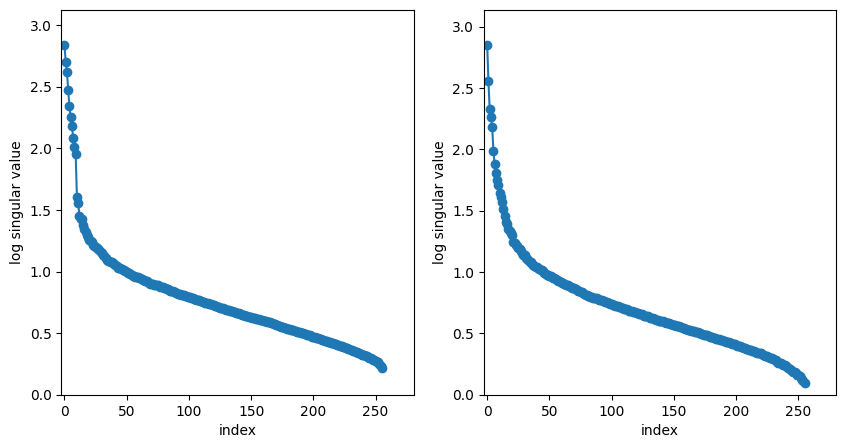

In [8]:
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
PCA().fit(train_cancer_features).plot_scree(log = True)
plt.subplot(1, 2, 2)
PCA().fit(train_dens_features).plot_scree(log = True)

In [9]:
aj = AJIVE(init_signal_ranks=[12,19], n_jobs=16, center=True)
aj.fit([train_cancer_features, train_dens_features])
aj.summary()


'AJIVE, joint rank: 3, view 0 indiv rank: 10, view 1 indiv rank: 16'

In [10]:
view_decomps = aj.get_view_decomps()
CJ = view_decomps[0]['joint']
CI = view_decomps[0]['individual']
DJ = view_decomps[1]['joint']
DI = view_decomps[1]['individual']


In [11]:
val_data = torch.load('saved_features/all_data_val.pt')
val_cancer_features = val_data['cancer_features'].numpy()
val_cancer_labels = val_data['cancer_labels'].numpy()
val_dens_features = val_data['dens_features'].numpy()
val_dens_labels = val_data['dens_labels'].numpy()

test_data = torch.load('saved_features/all_data_test.pt')
test_cancer_features = test_data['cancer_features'].numpy()
test_cancer_labels = test_data['cancer_labels'].numpy()
test_dens_features = test_data['dens_features'].numpy()
test_dens_labels = test_data['dens_labels'].numpy()

In [52]:
#train_cancer_enriched = np.hstack((train_cancer_features, aj.view_specific_[0].joint_.transform(train_cancer_features), aj.view_specific_[0].individual_.transform(train_cancer_features), aj.view_specific_[1].joint_.transform(train_dens_features)))
#val_cancer_enriched = np.hstack((val_cancer_features, aj.view_specific_[0].joint_.transform(val_cancer_features), aj.view_specific_[0].individual_.transform(val_cancer_features), aj.view_specific_[1].joint_.transform(val_dens_features)))
#test_cancer_enriched = np.hstack((test_cancer_features, aj.view_specific_[0].joint_.transform(test_cancer_features), aj.view_specific_[0].individual_.transform(test_cancer_features), aj.view_specific_[1].joint_.transform(test_dens_features)))
#train_cancer_enriched = np.hstack((train_cancer_features, train_dens_features))
#val_cancer_enriched = np.hstack((val_cancer_features, val_dens_features))
#test_cancer_enriched = np.hstack((test_cancer_features, test_dens_features))
train_cancer_enriched = aj.view_specific_[1].individual_.transform(train_dens_features)
val_cancer_enriched = aj.view_specific_[1].individual_.transform(val_dens_features)
test_cancer_enriched = aj.view_specific_[1].individual_.transform(test_dens_features)

In [44]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [45]:
class SimpleClassifier(pl.LightningModule):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], num_classes=5, dropout=0.3, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        # Build the network layers
        layers = []
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout)
            ])
            current_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(current_dim, num_classes))
        
        self.network = nn.Sequential(*layers)
        
        # Metrics tracking
        self.train_acc = []
        self.val_acc = []
        self.test_predictions = []
        self.test_targets = []
        
    def forward(self, x):
        return self.network(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return {'val_loss': loss, 'val_acc': acc}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        
        # Store predictions for confusion matrix
        self.test_predictions.extend(preds.cpu().numpy())
        self.test_targets.extend(y.cpu().numpy())
        
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        
        return {'test_loss': loss, 'test_acc': acc}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

In [46]:
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=64):
    """Create PyTorch DataLoaders from numpy arrays"""
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader

In [47]:
def train_and_evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, 
                            model_name="classifier", max_epochs=50, batch_size=64):
    """Train and evaluate a classification model"""
    
    # Create dataloaders
    train_loader, val_loader, test_loader = create_dataloaders(
        X_train, y_train, X_val, y_val, X_test, y_test, batch_size
    )
    
    # Initialize model
    input_dim = X_train.shape[1]
    model = SimpleClassifier(input_dim=input_dim, learning_rate=1e-3)
    
    # Setup trainer
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='mps' if torch.backends.mps.is_available() else 'cpu',
        devices=1,
        enable_progress_bar=True,
        enable_model_summary=True,
        logger=pl.loggers.CSVLogger("logs/", name=model_name),
        callbacks=[
            pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=True),
            pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, verbose=True)
        ]
    )
    
    # Train model
    print(f"\n=== Training {model_name} ===")
    print(f"Input dimensions: {input_dim}")
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")
    
    trainer.fit(model, train_loader, val_loader)
    
    # Test model
    print(f"\n=== Testing {model_name} ===")
    test_results = trainer.test(model, test_loader)
    
    # Generate confusion matrix - ensure model is on correct device
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        all_preds = []
        all_targets = []
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_targets, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(all_targets, all_preds))
    
    return model, test_results, all_preds, all_targets

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | network | Sequential | 298 K  | train
-----------------------------------------------
298 K     Trainable params
0         Non-trainable params
298 K     Total params
1.193     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


TRAINING ON ORIGINAL CANCER FEATURES

=== Training original_cancer_features ===
Input dimensions: 256
Training samples: 6400
Validation samples: 1598
Test samples: 2000


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.837
Epoch 0, global step 100: 'val_loss' reached 0.83695 (best 0.83695), saving model to 'logs/original_cancer_features/version_5/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 300: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.837. Signaling Trainer to stop.
Epoch 10, global step 1100: 'val_loss' was not in top 1



=== Testing original_cancer_features ===


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7059999704360962
        test_loss            1.001638412475586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


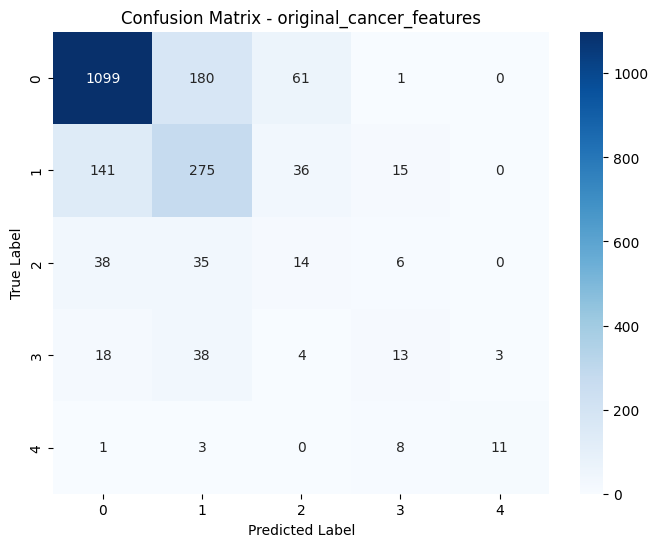


Classification Report - original_cancer_features:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1341
           1       0.52      0.59      0.55       467
           2       0.12      0.15      0.13        93
           3       0.30      0.17      0.22        76
           4       0.79      0.48      0.59        23

    accuracy                           0.71      2000
   macro avg       0.52      0.44      0.47      2000
weighted avg       0.72      0.71      0.71      2000



In [48]:
# Train model on original cancer features
print("=" * 60)
print("TRAINING ON ORIGINAL CANCER FEATURES")
print("=" * 60)

model_original, results_original, preds_original, targets_original = train_and_evaluate_model(
    train_cancer_features, train_cancer_labels,
    val_cancer_features, val_cancer_labels,
    test_cancer_features, test_cancer_labels,
    model_name="original_cancer_features",
    max_epochs=100
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | network | Sequential | 175 K  | train
-----------------------------------------------
175 K     Trainable params
0         Non-trainable params
175 K     Total params
0.701     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


TRAINING ON AJIVE-ENRICHED CANCER FEATURES

=== Training enriched_cancer_features ===
Input dimensions: 16
Training samples: 6400
Validation samples: 1598
Test samples: 2000


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.555
Epoch 0, global step 100: 'val_loss' reached 1.55529 (best 1.55529), saving model to 'logs/enriched_cancer_features/version_6/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.481
Epoch 1, global step 200: 'val_loss' reached 1.48083 (best 1.48083), saving model to 'logs/enriched_cancer_features/version_6/checkpoints/epoch=1-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.418
Epoch 2, global step 300: 'val_loss' reached 1.41779 (best 1.41779), saving model to 'logs/enriched_cancer_features/version_6/checkpoints/epoch=2-step=300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.398
Epoch 5, global step 600: 'val_loss' reached 1.39752 (best 1.39752), saving model to 'logs/enriched_cancer_features/version_6/checkpoints/epoch=5-step=600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.379
Epoch 6, global step 700: 'val_loss' reached 1.37882 (best 1.37882), saving model to 'logs/enriched_cancer_features/version_6/checkpoints/epoch=6-step=700.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.376
Epoch 8, global step 900: 'val_loss' reached 1.37552 (best 1.37552), saving model to 'logs/enriched_cancer_features/version_6/checkpoints/epoch=8-step=900.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 1100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.345
Epoch 12, global step 1300: 'val_loss' reached 1.34521 (best 1.34521), saving model to 'logs/enriched_cancer_features/version_6/checkpoints/epoch=12-step=1300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 1500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.344
Epoch 15, global step 1600: 'val_loss' reached 1.34358 (best 1.34358), saving model to 'logs/enriched_cancer_features/version_6/checkpoints/epoch=15-step=1600.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 1700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.330
Epoch 17, global step 1800: 'val_loss' reached 1.33013 (best 1.33013), saving model to 'logs/enriched_cancer_features/version_6/checkpoints/epoch=17-step=1800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 1900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 2000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 2100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 2200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.299
Epoch 22, global step 2300: 'val_loss' reached 1.29893 (best 1.29893), saving model to 'logs/enriched_cancer_features/version_6/checkpoints/epoch=22-step=2300.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 2400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 2500: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 2600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 2700: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 2800: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 2900: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 3000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 3100: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 3200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.299. Signaling Trainer to stop.
Epoch 32, global step 3300: 'val_loss' was not in top 1



=== Testing enriched_cancer_features ===


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.39100000262260437
        test_loss           1.3864768743515015
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


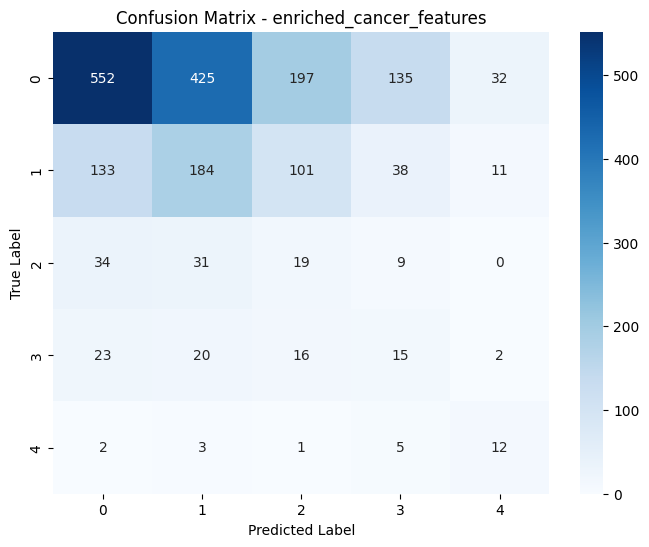


Classification Report - enriched_cancer_features:
              precision    recall  f1-score   support

           0       0.74      0.41      0.53      1341
           1       0.28      0.39      0.33       467
           2       0.06      0.20      0.09        93
           3       0.07      0.20      0.11        76
           4       0.21      0.52      0.30        23

    accuracy                           0.39      2000
   macro avg       0.27      0.35      0.27      2000
weighted avg       0.57      0.39      0.44      2000



In [53]:
# Train model on AJIVE-enriched cancer features
print("=" * 60)
print("TRAINING ON AJIVE-ENRICHED CANCER FEATURES")
print("=" * 60)

model_enriched, results_enriched, preds_enriched, targets_enriched = train_and_evaluate_model(
    train_cancer_enriched, train_cancer_labels,
    val_cancer_enriched, val_cancer_labels,
    test_cancer_enriched, test_cancer_labels,
    model_name="enriched_cancer_features",
    max_epochs=100
)

COMPARISON OF RESULTS
Original Cancer Features Test Accuracy: 0.7060
AJIVE-Enriched Features Test Accuracy: 0.7030
Improvement: -0.0030 (-0.42%)


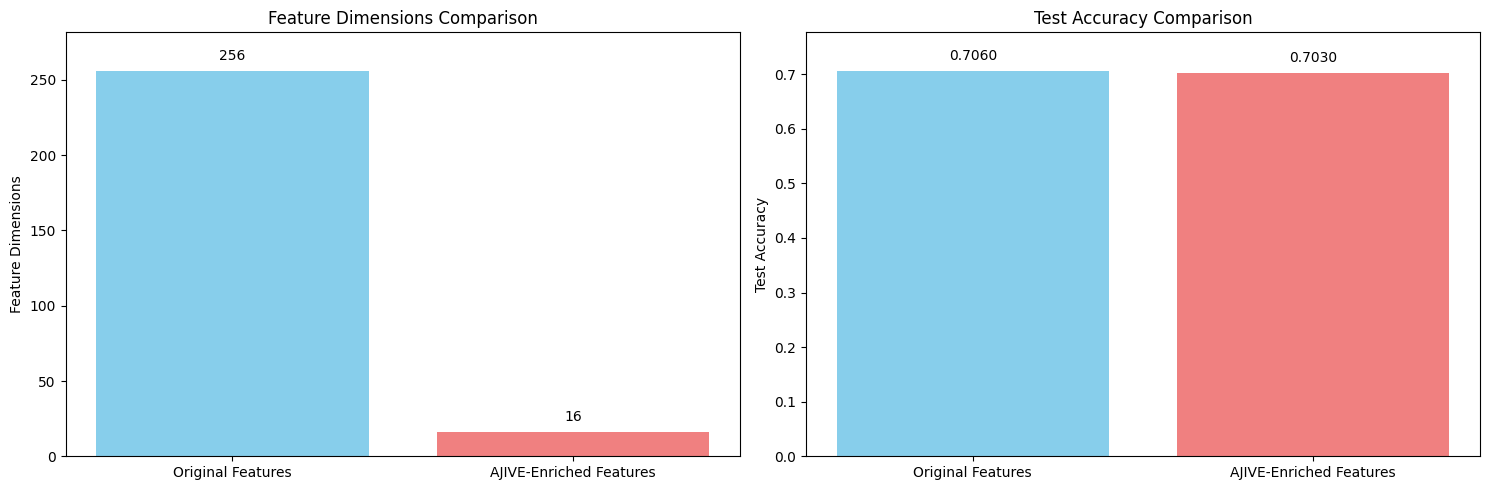

In [50]:
# Compare results
print("=" * 60)
print("COMPARISON OF RESULTS")
print("=" * 60)

# Extract test accuracies
acc_original = results_original[0]['test_acc']
acc_enriched = results_enriched[0]['test_acc']

print(f"Original Cancer Features Test Accuracy: {acc_original:.4f}")
print(f"AJIVE-Enriched Features Test Accuracy: {acc_enriched:.4f}")
print(f"Improvement: {acc_enriched - acc_original:.4f} ({((acc_enriched - acc_original) / acc_original * 100):.2f}%)")

# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot feature dimensions comparison
models = ['Original Features', 'AJIVE-Enriched Features']
dimensions = [train_cancer_features.shape[1], train_cancer_enriched.shape[1]]
accuracies = [acc_original, acc_enriched]

# Subplot 1: Feature dimensions
axes[0].bar(models, dimensions, color=['skyblue', 'lightcoral'])
axes[0].set_ylabel('Feature Dimensions')
axes[0].set_title('Feature Dimensions Comparison')
axes[0].set_ylim(0, max(dimensions) * 1.1)
for i, v in enumerate(dimensions):
    axes[0].text(i, v + max(dimensions) * 0.02, str(v), ha='center', va='bottom')

# Subplot 2: Test accuracies
axes[1].bar(models, accuracies, color=['skyblue', 'lightcoral'])
axes[1].set_ylabel('Test Accuracy')
axes[1].set_title('Test Accuracy Comparison')
axes[1].set_ylim(0, max(accuracies) * 1.1)
for i, v in enumerate(accuracies):
    axes[1].text(i, v + max(accuracies) * 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


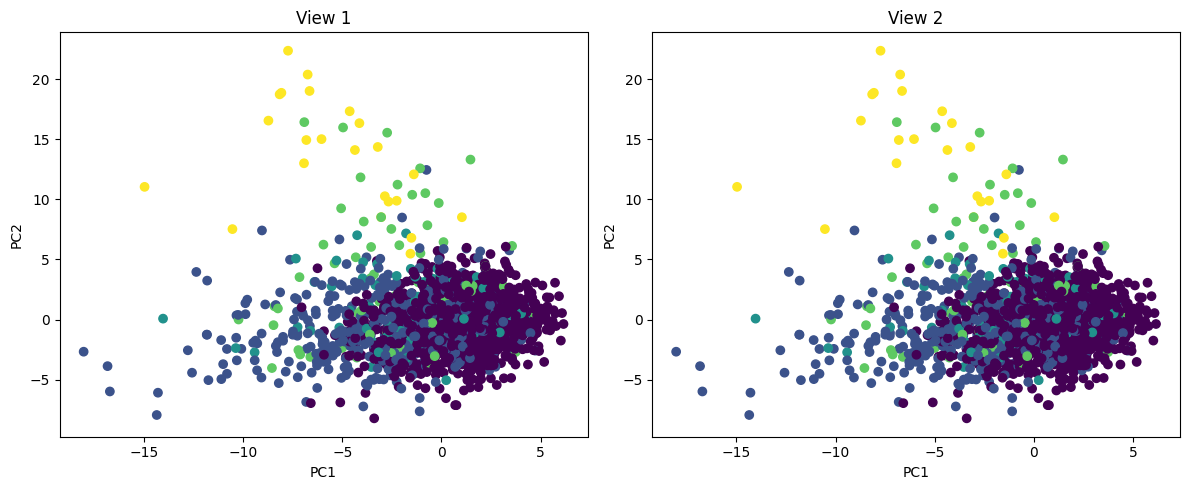

In [54]:
import sklearn
points = aj.view_specific_[0].joint_.transform(test_cancer_features)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    pca = sklearn.decomposition.PCA(n_components=2)
    X_pca = pca.fit_transform(points)
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=test_cancer_labels)
    axes[i].set_title(f'View {i+1}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
plt.tight_layout()
plt.show()

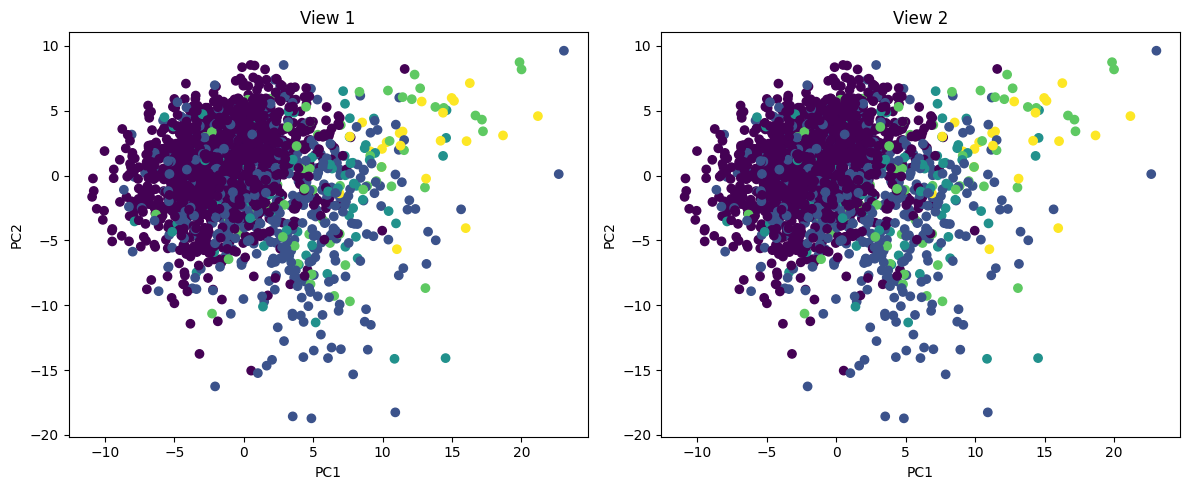

In [ ]:
import sklearn
points = aj.view_specific_[0].individual_.transform(test_cancer_features)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    pca = sklearn.decomposition.PCA(n_components=2)
    X_pca = pca.fit_transform(points)
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=test_cancer_labels)
    axes[i].set_title(f'View {i+1}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
plt.tight_layout()
plt.show()